# Preparação do Ambiente

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym
from torch.nn.utils import clip_grad_norm_

In [2]:
torch.manual_seed(42)

In [3]:
def moving_average(rewards, window_size=10):
    n = len(rewards)
    grouped_means = [np.mean(rewards[i:i+window_size]) for i in range(0, n, window_size)]
    grouped_indices = [i for i in range(0, n, window_size)]
    return grouped_indices, grouped_means

In [4]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None, window_size=10):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]

    # TRAINING
    axes[0].plot(train_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
    train_x, train_avg = moving_average(train_rewards, window_size)
    axes[0].plot(train_x, train_avg, label=f'Média a cada {window_size}', color='orange')
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward")

    if max_reward is not None:
        axes[0].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

    axes[0].legend()

    # TESTING
    if test_rewards is not None:
        axes[1].plot(test_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
        test_x, test_avg = moving_average(test_rewards, window_size)
        axes[1].plot(test_x, test_avg, label=f'Média a cada {window_size}', color='orange')
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Reward")

        if max_reward is not None:
            axes[1].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

        axes[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

# Replay Buffer

In [5]:
class ReplayBuffer:
   def __init__(self, capacity, observation_shape):
      self._index = 0
      self._size = 0
      self._capacity = capacity
      self._memory = {
         "states": np.zeros((capacity, *observation_shape), dtype=np.float32),
         "actions": np.zeros((capacity,), dtype=np.int32),
         "rewards": np.zeros((capacity,), dtype=np.float32),
         "next_states": np.zeros((capacity, *observation_shape), dtype=np.float32),
         "dones": np.zeros((capacity,), dtype=np.int32)
      }
   
   def add(self, state, action, reward, next_state, done):
      self._memory["states"][self._index] = state
      self._memory["actions"][self._index] = action
      self._memory["rewards"][self._index] = reward
      self._memory["next_states"][self._index] = next_state
      self._memory["dones"][self._index] = done
      self._index = (self._index + 1) % self._capacity
      self._size = min(self._size + 1, self._capacity)
   
   def sample(self, batch_size):
      indexes = np.random.choice(self._size, batch_size, replace=False)
      return (
         self._memory["states"][indexes],
         self._memory["actions"][indexes],
         self._memory["rewards"][indexes],
         self._memory["next_states"][indexes],
         self._memory["dones"][indexes]
      )
      
   def __len__(self):
      return self._size

# Definição da Rede

In [13]:
class DuelingDQN(nn.Module):
   def __init__(self, observation_shape, action_shape):
      super(DuelingDQN, self).__init__()
      self.projection_layer = nn.Sequential(
         nn.Linear(observation_shape[0], 128),
         nn.ReLU(),
      )
      
      self.return_layer = nn.Sequential(
         nn.Linear(128, 128),
         nn.ReLU(),
         nn.Linear(128, action_shape + 1)
      )
   
   def forward(self, x):
      x = self.projection_layer(x)
      result = self.return_layer(x)
         
      value = result[:, :1]
      advantage = result[:, 1:]

      q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
      return q

# Definição do Agente

In [14]:
class DuelingDQNAgent:
   def __init__(self, env,
                epsilon=1,
                alpha=1e-3,
                gamma=0.999,
                epsilon_decay=0.998,
                epsilon_min=0.01,
                batch_size=64,
                replay_buffer_size=100000,
                tau=0.005):
      self.epsilon = epsilon
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
      self.batch_size = batch_size
      self.tau = tau
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.env = env
      
      self.dqn = DuelingDQN(env.observation_space.shape, env.action_space.n).to(self.device)
      self.dqn_target = DuelingDQN(env.observation_space.shape, env.action_space.n).to(self.device)

      self.dqn_target.load_state_dict(self.dqn.state_dict())
      self.dqn_target.eval()
      
      self.replay = ReplayBuffer(replay_buffer_size, env.observation_space.shape)
      
      self.optimizer = optim.Adam(self.dqn.parameters(), lr=alpha)
      self.loss = nn.SmoothL1Loss()
      
      self.transaction = list()
      self.is_test = False
   
   def _update_dqn_target(self):
      self.dqn_target.load_state_dict(self.dqn.state_dict())

   def act(self, state):
      self.dqn.eval()
      
      if np.random.rand() < self.epsilon:
         action = self.env.action_space.sample()
      else:
         with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            action = self.dqn(state).argmax(dim=-1).item()
         
      if not self.is_test:
         self.transaction = [state, action]
      
      return action

   def step(self, action):
      next_state, reward, terminated, truncated, _ = self.env.step(action)
      done = terminated or truncated
      
      if not self.is_test:
         self.transaction += [reward, next_state, done]
         self.replay.add(*self.transaction)
      
      return next_state, reward, done
   
   def update(self):
      self.dqn.train()
      
      states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)
      
      states = torch.as_tensor(states).to(self.device)
      actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
      rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
      next_states = torch.as_tensor(next_states).to(self.device)
      dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)
      mask = 1 - dones
      
      q_eval = self.dqn(states).gather(-1, actions.long())
      
      with torch.no_grad():
         q_next = self.dqn_target(next_states).max(dim=-1)[0].unsqueeze(-1)
         q_target = (rewards + self.gamma * q_next * mask).to(self.device)
      
      loss = self.loss(q_eval, q_target)
      self.optimizer.zero_grad()
      loss.backward()
      clip_grad_norm_(self.dqn.parameters(), 10.0)
      self.optimizer.step()
         
   def train(self, episodes, verbose=False):
      self.is_test = False
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      rewards = []
            
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, done = self.step(action)
            state = next_state
            episode_reward += reward
            
            if len(self.replay) > self.batch_size:
               self.update()
         
         if episode % 50 == 0:
            self._update_dqn_target()
         
         self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
         
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward, "Epsilon": self.epsilon })
         
      return rewards
   
   def evaluate(self, episodes, verbose=False):
      self.is_test = True
      progress = tqdm(range(1, episodes + 1), desc="Evaluating", disable=not verbose)
      rewards = []
      
      epsilon_real = self.epsilon
      self.epsilon = 0
      
      self.dqn.eval()
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, done = self.step(action)
            state = next_state
            episode_reward += reward
            
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward })
      
      self.epsilon = epsilon_real
         
      return rewards

   def save(self, path):
      torch.save(self.dqn.state_dict(), path)
   
   def load(self, path):
      self.dqn.load_state_dict(torch.load(path))

# Ambientes

In [8]:
envs = [
    ("CartPole-v1",       "CartPole",       "cartpole_duelingodqn.pt",      500),
    ("Acrobot-v1",        "Acrobot",        "acrobot_duelingodqn.pt",       0),
    ("MountainCar-v0",    "MountainCar",    "mountaincar_duelingodqn.pt",   -50),
    ("LunarLander-v3",    "LunarLander",    "lunarlander_duelingodqn.pt",   200),
]

Training CartPole...


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 55.52it/s, Reward=99]


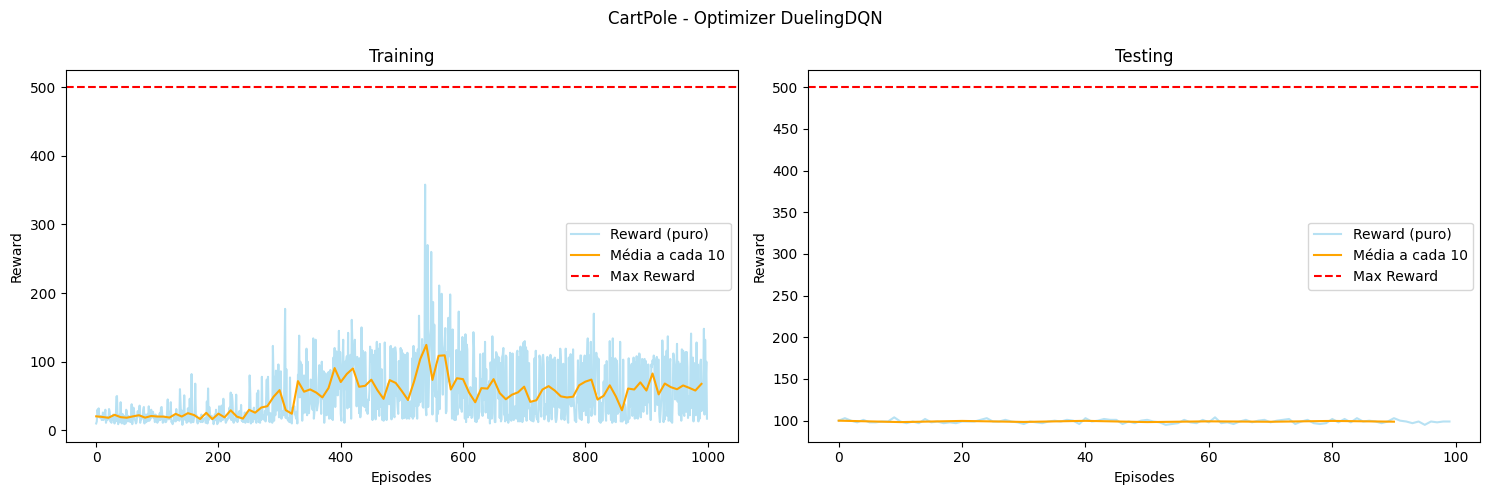

Done!

Training Acrobot...


Evaluating: 100%|██████████| 100/100 [00:12<00:00,  8.17it/s, Reward=-325]


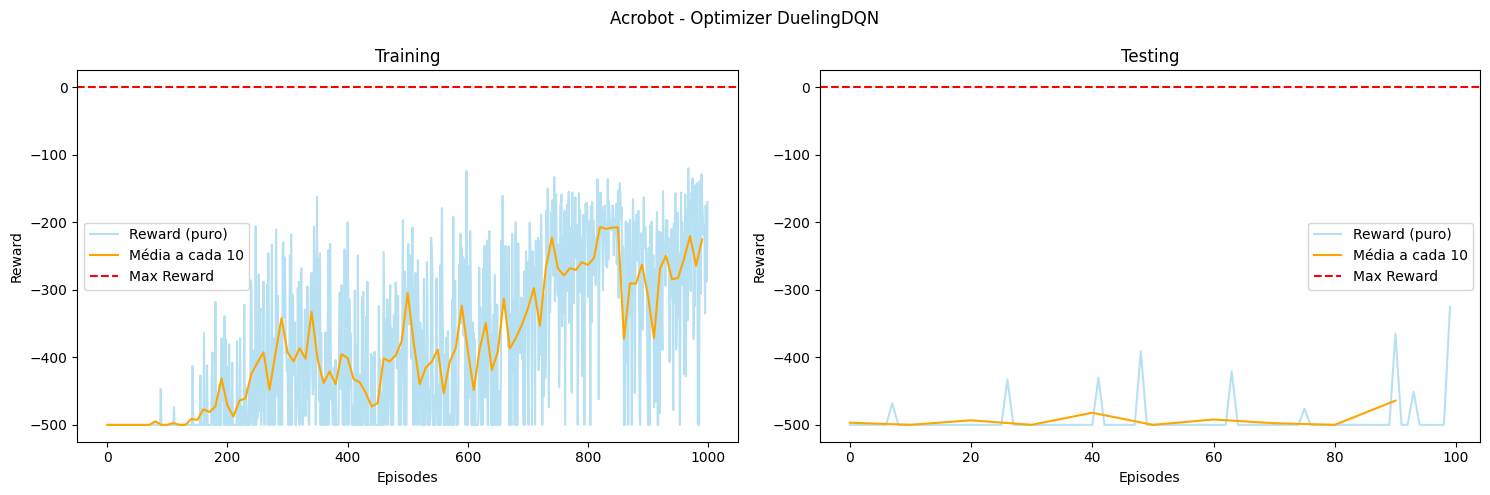

Done!

Training MountainCar...


Evaluating: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s, Reward=-200]


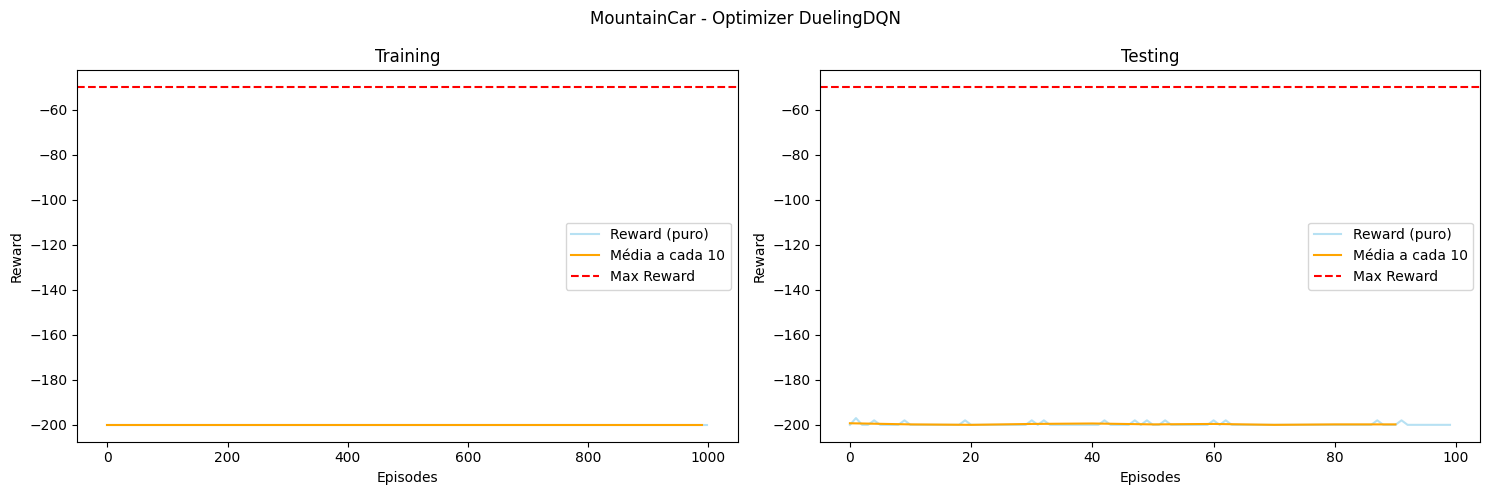

Done!

Training LunarLander...


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s, Reward=-134]


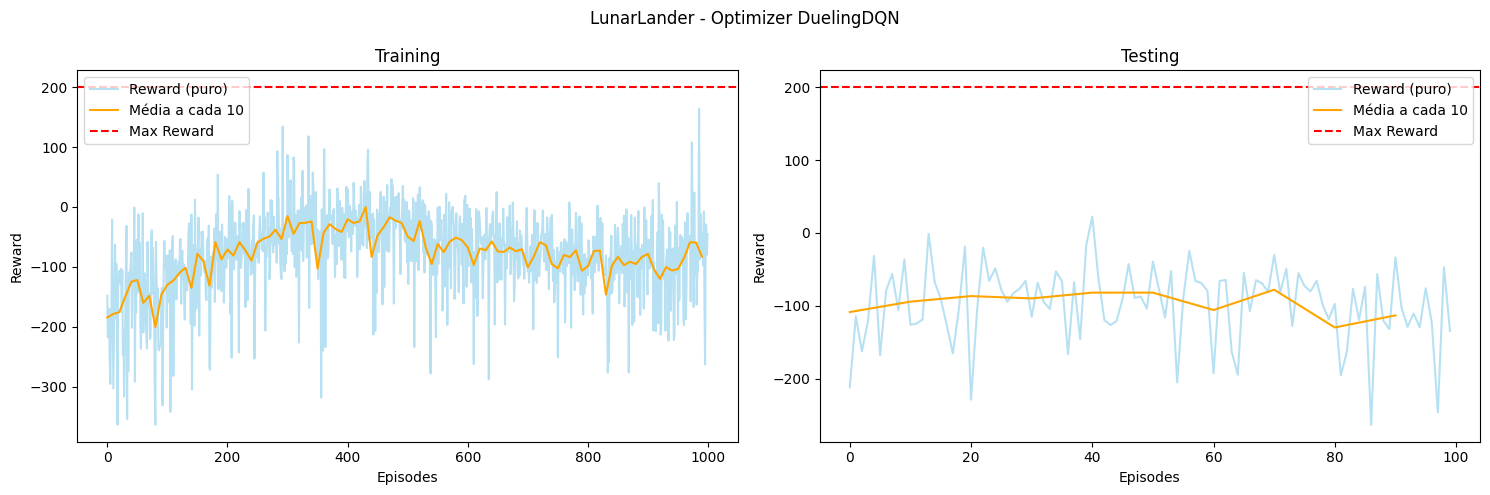

Done!



In [15]:
for env_name, env_title, path, max_reward in envs:
   print(f"Training {env_title}...")
   
   env = gym.make(env_name)
   agent = DuelingDQNAgent(env)
   
   train_rewards = agent.train(1000, verbose=True)
   test_rewards = agent.evaluate(100, verbose=True)
   
   agent.save(f'checkpoint/{path}')
   
   plot_rewards(train_rewards, test_rewards, f"{env_title} - Optimizer DuelingDQN", max_reward=max_reward)
      
   print("Done!\n")